★実行環境の選択

In [52]:
# VSCodeの場合
# edi_flg = 1
# Googlre Colabの場合
edi_flg = 0

In [53]:
if edi_flg == 0:
  # GoogleColabにGitHubリポジトリをクローンする用
  %cd /content/My_Python_project

  from google.colab import auth
  auth.authenticate_user()
  !git clone https://github.com/keiseki-eng/My_Python_project
  !git pull origin main



/content/My_Python_project
fatal: destination path 'My_Python_project' already exists and is not an empty directory.
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10 (delta 7), reused 6 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (10/10), 2.46 KiB | 96.00 KiB/s, done.
From https://github.com/keiseki-eng/My_Python_project
 * branch            main       -> FETCH_HEAD
   702e875..33827dd  main       -> origin/main
Updating 702e875..33827dd
Fast-forward
 ...\225\347\224\243\344\272\210\346\270\254.ipynb" | 141 +++++++++------------
 config/config.yaml                                 |   2 +-
 2 files changed, 61 insertions(+), 82 deletions(-)


In [54]:
# import sys
# !{sys.executable} -m pip install ipykernel

In [55]:
if edi_flg == 0:
    !pip install japanize-matplotlib

import os
import sys
import yaml
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import japanize_matplotlib #日本語表示対応


# Notebook から src ディレクトリを追加
# sys.path.append(os.path.join(os.getcwd(), "src"))
sys.path.append("/home/keiseki/My_Python_project/src")

# これで src/preprocess/make_tag_features.py が import 可能
# from preprocess.make_tag_features import create_tag_features, extract_unique_tags

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=pd.errors.PerformanceWarning
)

## 01.config読み込み

In [58]:
# VSCode用
if edi_flg==1:
  conf_path = os.path.join( '../config/config.yaml')
  with open(conf_path, 'r') as f:
    config = yaml.safe_load(f)

# GoogleColab用
elif edi_flg==0:
  conf_path = "My_Python_project/config/config.yaml"
  with open(conf_path, "r") as f:
    config = yaml.safe_load(f)

In [59]:
# 定義した特徴量リストを読み込み
feature_list = config['FEATURE']['FEATURE_LIST']

In [60]:
# カテゴリカルカラムのリストを定義
categorical_cols = config['FEATURE']['CATEGORICAL_COLS']

## 02.データ読み込み

In [61]:
# VSCode用
if edi_flg==1:
# ドライブ内のファイルパスを指定
    train_path = '../20.Data/processed_train.pkl'
    df_train = pd.read_pickle(train_path)

# GoogleColab用
elif edi_flg==0:
    # GoogleDriveをマウントしてファイル読み込み準備
    from google.colab import drive
    drive.mount('/content/drive')
    # ドライブ内のファイルパスを指定
    train_path = '/content/drive/MyDrive/Colab Notebooks/不動産予測/processed_train.pkl'
    df_train = pd.read_pickle(train_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# testデータの読み込み
# VSCode用
if edi_flg==1:
    test_path = '../20.Data/processed_test.pkl'
    df_test = pd.read_pickle(test_path)

# GoogleColab用
elif edi_flg==0:
    # ドライブ内のファイルパスを指定
    test_path = '/content/drive/MyDrive/Colab Notebooks/不動産予測/processed_test.pkl'
    df_test = pd.read_pickle(test_path)

## 05.train/valid 分割　＆　target加工

In [63]:
# X_all, X_train, X_validの再構築
X_all = df_train[feature_list]
y_all = df_train["money_room"]

# log変換前の元価格を保存（後段の重み付け用）
y_price_raw = df_train.loc[X_all.index, "money_room"]

# unit_areaも対数変換
X_all["unit_area"] = np.log1p(X_all["unit_area"])

# 価格帯を5分割してカテゴリ変数化
X_all["price_band"] = pd.qcut(
    y_price_raw, q=5, labels=False
)
categorical_cols.append("price_band")
# df_testにも反映
df_test["price_band"] = pd.qcut(
    df_test["money_room"], q=5, labels=False
)



# 目的変数が右に裾野が広いので対数変換
y_all = np.log1p(y_all)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


/tmp/ipython-input-2883297136.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_all["unit_area"] = np.log1p(X_all["unit_area"])
/tmp/ipython-input-2883297136.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_all["price_band"] = pd.qcut(


## 06.sample_weight適用

In [64]:
# 元スケールの価格
y_price = y_all


# train / valid に合わせる
y_price_raw_train = y_price_raw.loc[X_train.index]

# 低価格ほど重く（価格の逆数）
sample_weight = 1 / np.log1p(np.maximum(y_price_raw_train, 1_000_000)* np.where(y_price_raw_train < 13_000_000, 2.0, 1.0)** 0.7 )

# 正規化
sample_weight = sample_weight / sample_weight.mean()

## 07.モデル学習

In [65]:
# カスタム評価関数（eval_metric形式）
def mape_eval(preds, train_data):
    y_true = np.expm1(train_data.get_label())
    y_pred = np.expm1(preds)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-7))) * 100
    return 'mape', mape, False


In [66]:
# LightGBM のパラメータ設定
params = config['MODEL_PARAMS']

# LightGBM のデータセットを作成
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    weight=sample_weight.loc[X_train.index],
    categorical_feature=categorical_cols
)

lgb_test = lgb.Dataset(
    X_valid,
    y_valid,
    reference=lgb_train,
    categorical_feature=categorical_cols
)


In [67]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  feval=mape_eval,  # ← カスタム評価関数を指定
                  callbacks=[lgb.early_stopping(stopping_rounds=1000, verbose=False)
                  ]) #early_stoppingあり


## 08.評価

特徴量の重要度


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

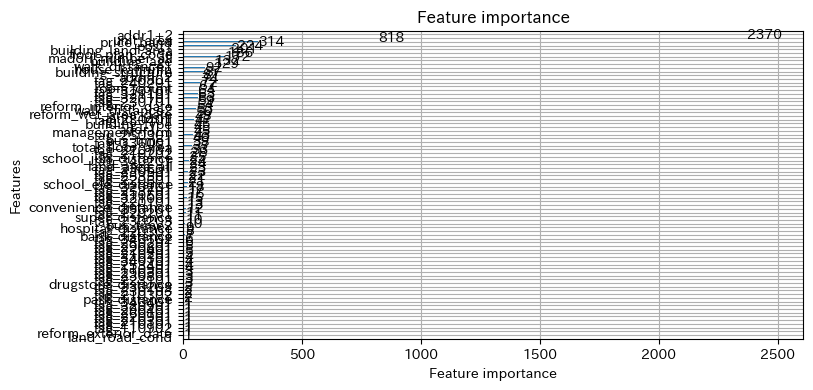

In [68]:
# テストデータで予測
y_pred = model.predict(X_valid , num_iteration=model.best_iteration)

# 対数変換を戻す
y_pred = np.expm1(y_pred)
y_valid = np.expm1(y_valid)

# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
# y_pred = np.where(y_pred < 6000000, y_pred * 1.5, y_pred)
# y_valid = np.where(y_valid < 6000000, y_valid * 1.5, y_valid)


yp = pd.DataFrame(y_pred,columns=["%"])




# 特徴量の重要度
print("特徴量の重要度")
lgb.plot_importance(model, figsize=(8,4))


## 09.可視化（importance SHAP）

In [69]:

# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV

# # パラメータの探索範囲を指定
# param_grid = {
#     'num_leaves': [20, 30, 40],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_depth': [5, 10]
# }




# # グリッドサーチCV
# gsearch = GridSearchCV(gbm, param_grid, cv=5) #cvは交差検証の回数

# # データを学習
# gsearch.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])



# # 最適なパラメータとスコアを表示
# print('Best parameters found by grid search are:', gsearch.best_params_)
# print('Best score:', gsearch.best_score_)


In [70]:
# # パラメータの辞書を結合
# best_params = {**params, **gsearch.best_params_}

# # 最適パラメータでモデルを再学習
# model = lgb.LGBMClassifier(**best_params)
# model.fit(X_train, y_train)

In [71]:
#SHAP値の取得
explainer = shap.TreeExplainer(model=model)#SHAP値を取得するためのモデル作成
shap_values = explainer.shap_values(X=X_valid)#説明変数それぞれの値のSHAP値を取得する

# print(shap_values)
# print(shap_values.shape)


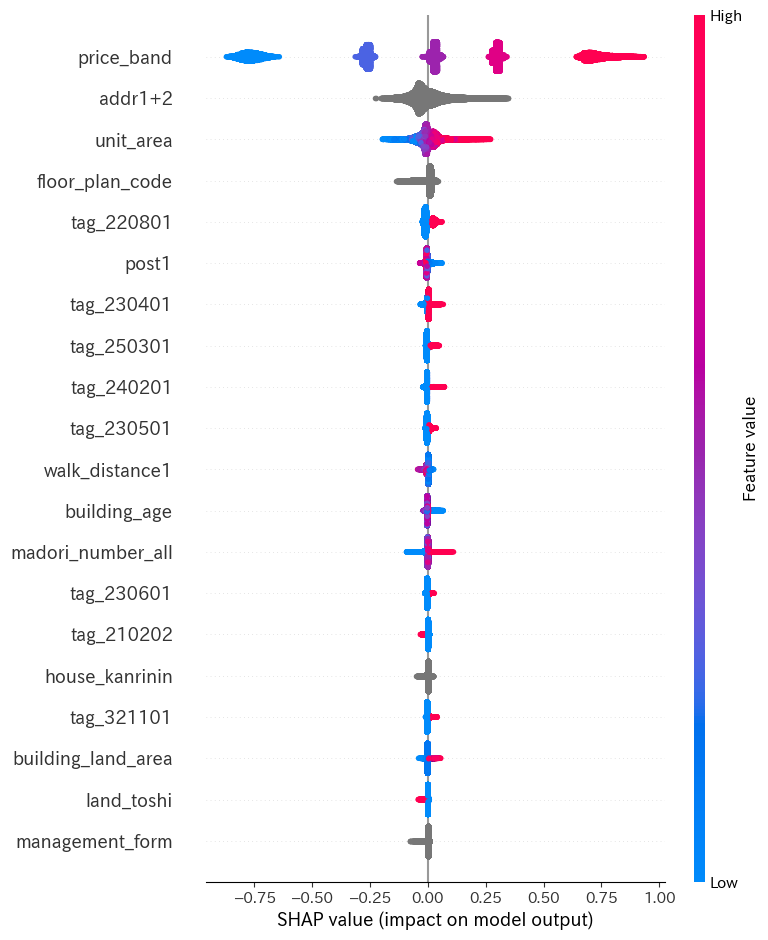

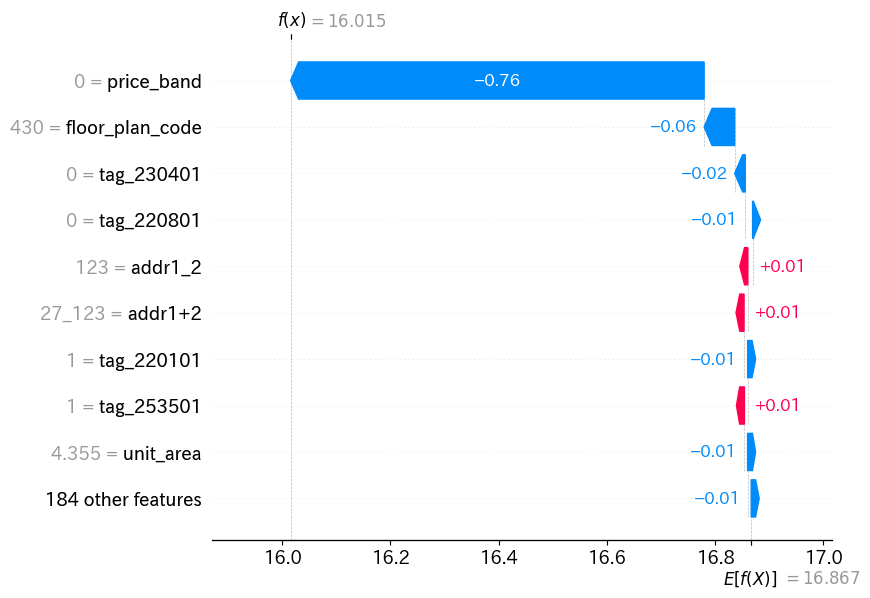

In [72]:

# 変数別の影響度の可視化
shap.initjs()
shap.summary_plot(shap_values, X_valid)

# 0番目のデータポイントを再選択
i = 0
single_observation = X_valid.iloc[i:i+1,:]

#print(single_observation)


# Explainerを使って説明を再計算
single_shap_values = explainer(single_observation)

# waterfallプロットの生成
shap.waterfall_plot(single_shap_values[0])

## 10.推論、提出

## 提出用データの作成

In [73]:
# 特徴量の選定
df_test_p = df_test[feature_list].copy()
df_test_p["unit_area"] = np.log1p(df_test_p["unit_area"])



# 提出データに対する予測（確率値）
y_scores_submit = model.predict(df_test_p)
# # y_scores_binary_submit = np.where(y_scores_submit>0.5, 1, 0)


y_scores_submit= np.expm1(y_scores_submit)

# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
# y_scores_submit = np.where(y_scores_submit < 6000000, y_scores_submit * 1.5, y_scores_submit)


print(y_scores_submit)

# y_scores_survive_submit = y_scores_submit[:, 1]

LightGBMError: The number of features in data (192) is not the same as it was in training data (193).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:



#提出用csvの作成
df_scores_submit = pd.DataFrame(y_scores_submit)

# df_submit = pd.concat([df_test["id"], df_scores_submit], axis=1)
# df_scores_submit.index = df_scores_submit.index + 1
df_scores_submit.to_csv("submit.csv", index=True, header=False)




In [ ]:
# テストデータに対する予測（確率値）？？？？？？？？？？？？？？？？？？？？？？？・
y_scores = model.predict(X_valid)
# y_scores

## 誤差要因分析

In [ ]:
# valid予測
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
# 対数変換を戻す
y_pred_valid = np.expm1(y_pred_valid)
# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
# y_pred_valid = np.where(y_pred_valid < 6000000, y_pred_valid * 1.5, y_pred_valid)





df_eval = X_valid.copy()
df_eval["y_true"] = y_valid
df_eval["y_pred"] = y_pred_valid

# APE計算（0割防止）
df_eval["ape"] = np.abs(df_eval["y_true"] - df_eval["y_pred"]) / np.maximum(df_eval["y_true"], 1e-7)

# 上位ワースト確認
# df_eval.sort_values("ape", ascending=False).head(20)
df_eval["スコア差分"] = df_eval["y_true"] - df_eval["y_pred"]
df_eval["スコア差分"].plot.hist(bins=50, figsize=(10,5))

In [ ]:
# 価格帯ビン作成
df_eval["price_bin"] = pd.qcut(df_eval["y_true"], q=5)

# 価格帯別MAPE
mape_by_bin = df_eval.groupby("price_bin")["ape"].mean() * 100
print("価格帯別のMAPE\n", mape_by_bin)
print()
print("全データのMAPE", df_eval["ape"].mean())
print()


In [ ]:
def compare_distribution(col):
    return pd.DataFrame({
        "train": df_train[col].describe(),
        "valid": X_valid[col].describe()
    })

# compare_distribution("money_rimawari_now")


In [ ]:
# APEが大きい上位10%
threshold = df_eval["ape"].quantile(0.9)
bad_samples = df_eval[df_eval["ape"] >= threshold]

# SHAP値抽出
shap_values_valid = explainer.shap_values(X_valid)
shap_df = pd.DataFrame(
    shap_values_valid,
    columns=X_valid.columns,
    index=X_valid.index
)


# 悪いサンプルのSHAP平均
shap_df.loc[bad_samples.index].abs().mean().sort_values(ascending=False).head(10)


In [ ]:
# shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=X_train)

In [ ]:
def calc_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-7))) * 100


# valid 予測
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
# 対数変換を戻す
y_pred_valid = np.expm1(y_pred_valid)
# ★小細工:予測値が低価格帯であれば、予測値を1.5倍にする
# y_pred_valid = np.where(y_pred_valid < 6000000, y_pred_valid * 1.5, y_pred_valid)

# MAPE 出力
valid_mape = calc_mape(y_valid, y_pred_valid)
print(f"VALID MAPE: {valid_mape:.4f}%")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 対数変換を戻した y_pred_valid と y_valid はすでに存在すると仮定

# X_valid["unite_area"] = np.expm1(X_valid["unit_area"])

df_eval = X_valid.copy()
df_eval["unit_area"] = np.expm1(df_eval["unit_area"])
df_eval["y_true"] = y_valid
df_eval["y_pred"] = y_pred_valid
df_eval["ape"] = np.abs(df_eval["y_true"] - df_eval["y_pred"]) / np.maximum(df_eval["y_true"], 1e-7)

# 上位10%の誤差サンプル抽出
threshold = df_eval["ape"].quantile(0.9)
bad_samples = df_eval[df_eval["ape"] >= threshold]

# 調査対象の特徴量リスト
check_features = [
    "unit_area",
    "post1",
    "floor_plan_code",
    "walk_distance1",
    "walk_distance2",
]

# タグ系カラムを抽出（feature_list に基づく）
tag_features = [col for col in feature_list if col.startswith("tag_")]
check_features.extend(tag_features)

# 1. 数値特徴量の誤差 vs 値域の関係
num_features = ["unit_area", "walk_distance1", "walk_distance2"]
for col in num_features:
    plt.figure(figsize=(8,4))
    sns.scatterplot(data=df_eval, x=col, y="ape", alpha=0.3)
    sns.scatterplot(data=bad_samples, x=col, y="ape", color="red", alpha=0.5)
    plt.title(f"{col} と予測誤差(APE)の関係")
    plt.ylabel("APE")
    plt.xlabel(col)
    plt.show()

# 2. カテゴリ特徴量の誤差分布（箱ひげ図）
cat_features = ["post1", "floor_plan_code"]
for col in cat_features:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=col, y="ape", data=df_eval)
    plt.title(f"{col} ごとの予測誤差(APE)分布")
    plt.xticks(rotation=45)
    plt.show()

# 3. タグ系特徴量の影響（悪いサンプルと全体比較）
for col in tag_features:
    if col not in df_eval.columns:
        continue
    mean_all = df_eval[col].mean()
    mean_bad = bad_samples[col].mean()
    print(f"{col}: 全体平均={mean_all:.3f}, 誤差上位10%平均={mean_bad:.3f}")


In [ ]:
df_eval["unit_area"] = np.expm1(df_eval["unit_area"])
X_valid["unit_area"]